# Image Recognition

Develop an image recognitio model using the pre-trained model (VGG16).

You have to make a Dataset class before training, then evaluate the model.

VGG16: https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

Dataset: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset/code

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install opendatasets
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download jehanbhathena/weather-dataset
!unzip /content/weather-dataset.zip
clear_output()

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import random
import matplotlib.pyplot as plt

## Data Handling

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Get the folder names and sort them
        self.image_paths = []
        self.labels = []

        # Iterate through each class directory and collect image paths and labels
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_path in glob.glob(os.path.join(class_dir, '*')):
                self.image_paths.append(img_path)
                self.labels.append(label)

        # Shuffle the dataset
        combined = list(zip(self.image_paths, self.labels))
        random.shuffle(combined)
        self.image_paths[:], self.labels[:] = zip(*combined)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
#transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 as required by ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as required by ResNet
])

# Initialize the dataset
dataset = CustomImageDataset(root_dir='dataset', transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
b_size = 32
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_loader =   DataLoader(val_dataset, batch_size=b_size)
test_loader =  DataLoader(test_dataset, batch_size=b_size)

## VGG16 Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 11)  # Modify the final layer to match the number of classes --> 11
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.5MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_dataset)
    training_accuracy = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_dataset)
    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f} - Training Accuracy: {training_accuracy:.2f}% - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1/10, Training Loss: 0.7069 - Training Accuracy: 76.77% - Validation Loss: 0.4954 - Validation Accuracy: 83.09%
Epoch 2/10, Training Loss: 0.4418 - Training Accuracy: 84.26% - Validation Loss: 0.4543 - Validation Accuracy: 84.99%
Epoch 3/10, Training Loss: 0.3867 - Training Accuracy: 86.15% - Validation Loss: 0.4327 - Validation Accuracy: 85.86%
Epoch 4/10, Training Loss: 0.3517 - Training Accuracy: 87.96% - Validation Loss: 0.4240 - Validation Accuracy: 86.30%
Epoch 5/10, Training Loss: 0.3462 - Training Accuracy: 87.58% - Validation Loss: 0.4401 - Validation Accuracy: 85.42%
Epoch 6/10, Training Loss: 0.3226 - Training Accuracy: 88.21% - Validation Loss: 0.4806 - Validation Accuracy: 84.55%
Epoch 7/10, Training Loss: 0.3108 - Training Accuracy: 88.70% - Validation Loss: 0.4553 - Validation Accuracy: 84.55%
Epoch 8/10, Training Loss: 0.2954 - Training Accuracy: 89.16% - Validation Loss: 0.4797 - Validation Accuracy: 85.28%
Epoch 9/10, Training Loss: 0.2909 - Training Accuracy: 8

In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_dataset)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Training and evaluation complete')

Test Loss: 0.2997, Test Accuracy: 89.08%
Training and evaluation complete


## Plot sample of predictions

In [ ]:
# Example: Load a batch from DataLoader
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

# Example: Apply model to batch of images
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest probability

# Mean and std for normalization (as used in training)
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Function to denormalize a single image tensor
def denormalize(image_tensor):
    return torch.clamp(image_tensor * std[:, None, None] + mean[:, None, None], 0, 1)

# Denormalize images
images_denorm = [denormalize(images[i]) for i in range(images.shape[0])]

# Convert tensors to numpy arrays for plotting
images_np = [img.cpu().numpy() for img in images_denorm]
labels_true = labels.cpu().numpy()
labels_pred = predicted.cpu().numpy()

# Create a grid of images
num_images = len(images_np)
rows = int(np.sqrt(num_images))
cols = num_images // rows if num_images % rows == 0 else num_images // rows + 1

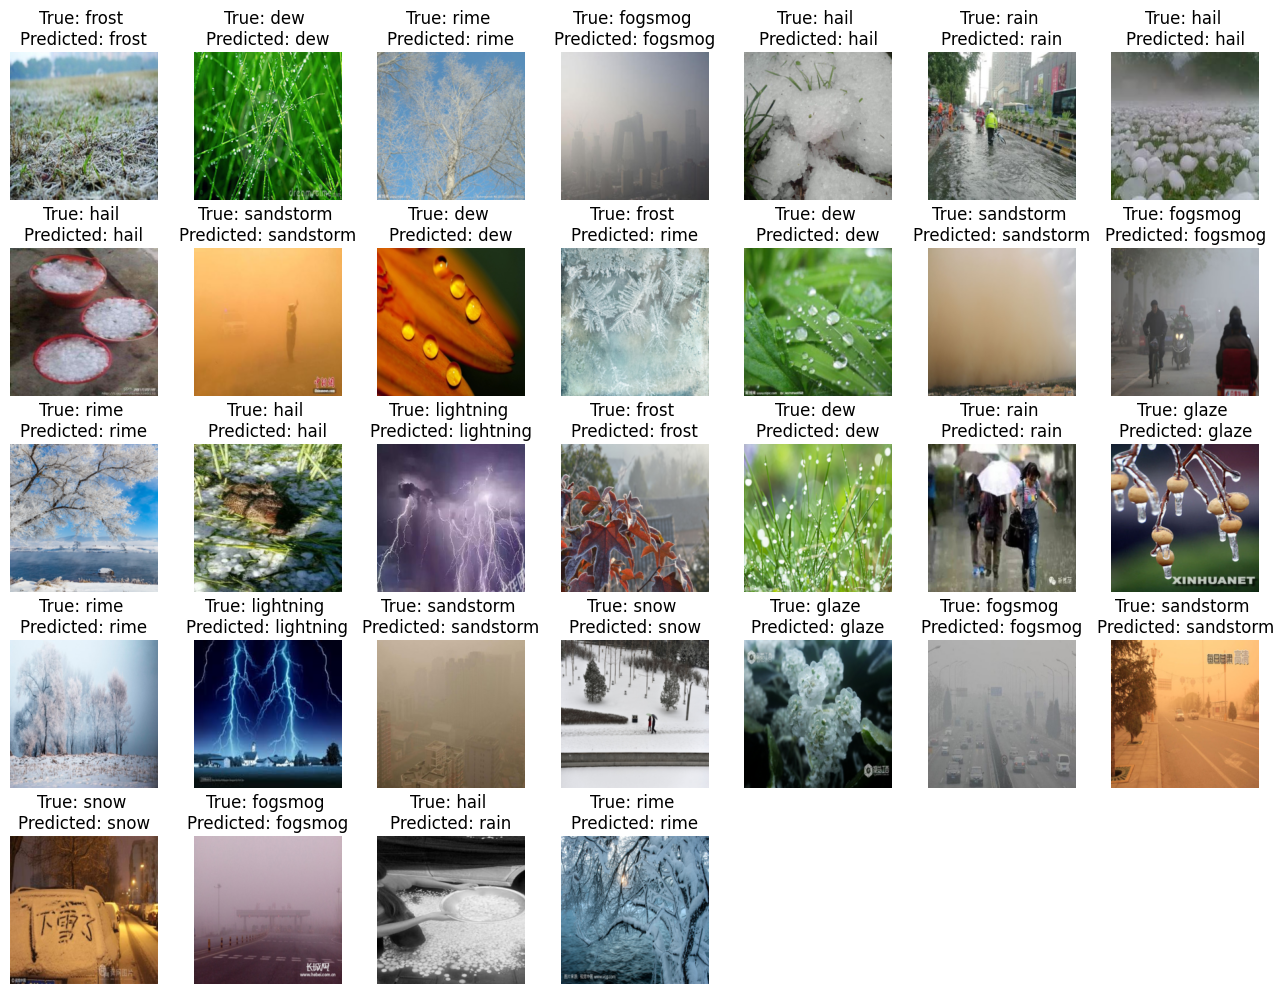

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(13, 10))
if labels_pred is None:
    labels_pred = labels_true

for i, ax in enumerate(axes.flat):
    if i < num_images:
        # Plot image
        ax.imshow(np.transpose(images_np[i], (1, 2, 0)))
        ax.axis('off')
        pre_class_name = dataset.classes[labels_pred[i]]
        true_class_name = dataset.classes[labels_true[i]]
        # Show true and predicted labels
        ax_title = f"True: {true_class_name} \nPredicted: {pre_class_name}"
        ax.set_title(ax_title)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()